In [68]:
# Importy bibliotek
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv',sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)


In [70]:
#Age to int

def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [71]:
# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID','EMPL_ID', 'WORK_START', 'WORK_STOP', 'LOGICAL_FACTOR_1','LOGICAL_FACTOR_2','ID','PKD_CODE','PPK_BANK','NUMERICAL_VALUE'], inplace=True)

In [72]:
# Grouping other nationalities into one category '0'
unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0       

In [73]:
# zamiana danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'], 
                         prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'])

In [74]:
# 
def find_period(data):
    start, stop = data
    if type(stop) is float:
        stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['CREATED_AT'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

df['RESIGNED'] = ~df['RESIGN_DATE'].isna()

df.drop(columns = ['SIGN_DATE', 'RESIGN_DATE'], inplace=True)
# z tym nie wiem co mam zrobic, mozna wyjebac albo cos mądrego zrobic
df.drop(columns=["CREATED_AT", "UOZ_START_DATE", "UOP_SIGN_DATE", 'REGION_CODE'], inplace=True)

### wyrzucenie paru kolumn co nie pasują narazie i TEST/TRAIN split

In [75]:
# ta kolumna to w ogole jest 100% skorelowana z targetem, pozdro
df.drop(columns=["RESIGNED"], inplace = True)

# to tez jest podejrzanie skorelowane
# df.drop(columns=["DURATION"], inplace = True)

In [76]:
df.columns


Index(['IS_SUSPENDED', 'AGE', 'HAS_AE', 'HAS_AW', 'HAS_IP', 'SEX_K', 'SEX_M',
       'SEX_N', 'COMPANY_SIZE_A', 'COMPANY_SIZE_B', 'COMPANY_SIZE_C',
       'COMPANY_SIZE_D', 'COMPANY_SIZE_E', 'COMPANY_SIZE_F', 'COMPANY_SIZE_G',
       'COMPANY_SIZE_H', 'COMPANY_TYPE_1.0', 'COMPANY_TYPE_2.0',
       'COMPANY_TYPE_3.0', 'COMPANY_TYPE_4.0', 'COMPANY_TYPE_5.0',
       'COMPANY_TYPE_6.0', 'COMPANY_TYPE_7.0', 'COMPANY_TYPE_9.0',
       'COMPANY_TYPE_10.0', 'COMPANY_TYPE_11.0', 'COMPANY_TYPE_12.0',
       'COMPANY_TYPE_13.0', 'COMPANY_TYPE_14.0', 'COMPANY_TYPE_16.0',
       'COMPANY_TYPE_17.0', 'COMPANY_TYPE_18.0', 'COMPANY_TYPE_19.0',
       'COMPANY_TYPE_20.0', 'COMPANY_TYPE_21.0', 'COMPANY_TYPE_22.0',
       'COMPANY_TYPE_23.0', 'COMPANY_TYPE_24.0', 'COMPANY_TYPE_25.0',
       'VOIVODESHIP_DOLNOŚLĄSKIE', 'VOIVODESHIP_KUJAWSKO-POMORSKIE',
       'VOIVODESHIP_LUBELSKIE', 'VOIVODESHIP_LUBUSKIE',
       'VOIVODESHIP_MAZOWIECKIE', 'VOIVODESHIP_MAŁOPOLSKIE',
       'VOIVODESHIP_OPOLSKIE', 'VOIVOD

In [77]:
#POSITIVE = SUSPENDED jak cos

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df["IS_SUSPENDED"], stratify=df["IS_SUSPENDED"], test_size=0.10, random_state=56)
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

/home/przemek/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.98


In [78]:
y_pred = xgb_model.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    148055
           1       0.99      0.91      0.95     31267

    accuracy                           0.98    179322
   macro avg       0.98      0.95      0.97    179322
weighted avg       0.98      0.98      0.98    179322



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

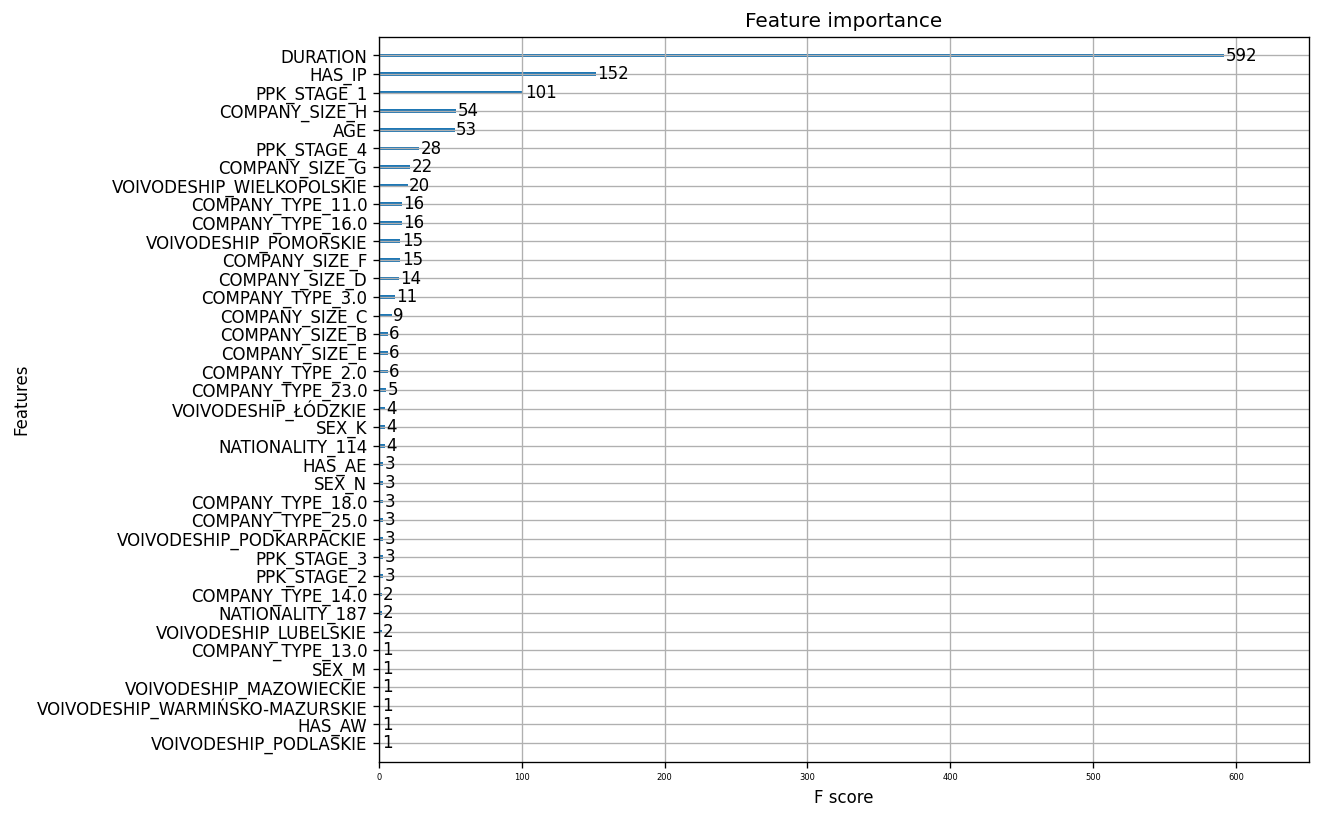

In [80]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [81]:
df['proba'] = xgb_model.predict_proba(df[X_train.columns])[:,1]
df[['AGE','proba']].head(50)

,AGE,proba
0,62,0.003539
1,85,0.025298
2,82,0.025298
3,67,0.025304
4,91,0.025298
5,67,0.094783
6,78,0.025298
7,68,0.025304
8,74,0.025298
9,65,0.003539


In [84]:
# dane testowe
testowe = pd.read_csv('data/PPK_Uczestnicy_TEST.csv',sep=';')

In [85]:
testowe.columns

Index(['MEMBER_ID', 'EMPL_ID', 'SEX', 'NATIONALITY', 'WORK_START', 'WORK_STOP',
       'PPK_BANK', 'AGE', 'CREATED_AT', 'NUMERICAL_VALUE', 'UOZ_START_DATE',
       'UOP_SIGN_DATE', 'SIGN_DATE', 'RESIGN_DATE', 'HAS_AE', 'HAS_AW',
       'HAS_IP'],
      dtype='object')

In [87]:
testowe["RESIGN_DATE"].value_counts()

2019-11-10    10420
2019-08-12     7307
2020-11-26     3683
2019-09-05     3557
2020-02-05     3076
              ...  
2020-09-08        1
2020-03-10        1
2019-04-10        1
2019-05-04        1
2020-07-14        1
Name: RESIGN_DATE, Length: 522, dtype: int64

In [88]:
testowe["RESIGN_DATE"].isna().sum()

797056